<a href="https://colab.research.google.com/github/noldest/noldest-desmos-renderer/blob/main/noldest's_recreation_of_junferno's_desmos_renderer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## noldest's recreation of Junferno's Desmos Renderer

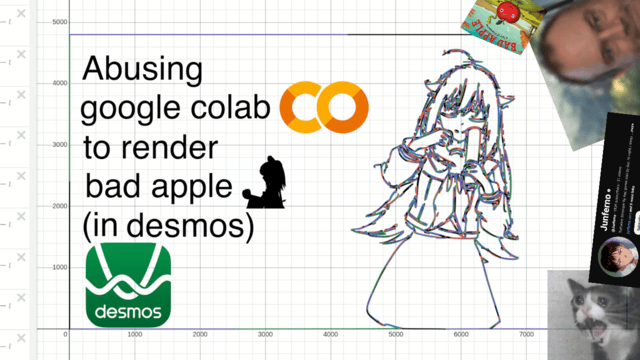

[The video that goes over how I made this](https://youtu.be/4dx3xqoDRgQ)


This Desmos Renderer is based heavily on [Junferno's version](https://www.youtube.com/watch?v=BQvBq3K50u8). However, you can run this one directly in your webbrowser

*also the lines in the final version will jitter between colors (i think its pretty)*

The performance isn't fantastic, it takes a few minutes (like up to 30 minutes if larger video) to download stuff and run a bunch of convertions, then it renders the frames at approximately 10-25 seconds per frame


---

To use this, you'll need:

- your desired mp4 file
- A new google drive folder called "Desmos Renderer" (honestly any name will work as long is it matches
> content/drive/My Drive/Desmos Renderer/Input MP4
- A sub-folder inside "Desmos Renderer" called "Input MP4" (I dunno if caps matter, copy it just in case)

The rest of the folders should be created automatically under "Desmos Renderer"

after that, go to the Runtime tab (on the top left bar) and run all, or you can go through the cells and run them in order 1 by 1 as you read through my incredible writing, good for learning too

(if you are resuming your render because colad disconnected you, you can probably just mount your drive, download the libraries, and skip the code blocks you already ran)

In [ ]:
# input mp4 file comes from here
input_dir = '/content/drive/My Drive/Desmos Renderer/Input MP4'

this part is going to ask you for google drive permission, im not hacking you

In [ ]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

this part downloads a bunch of packages we'll be using, i dont know if we will be using all of them, some might be leftovers from when i was testing stuff:
- !pip install downloads the python ones
- !apt-get downloads the others to linux (colab runs on ubuntu, i think), if you are somehow running this locally, find a way to download these packages

In [ ]:
!apt-get install potrace
!apt-get install imagemagick

# Install selenium
!apt-get update
!apt-get install -y chromium-chromedriver
!pip install selenium

!pip install svgpathtools
!pip install opencv-python-headless natsort

The overall idea here is that we take the mp4, slice it into png files, convert them into something we can graph on desmos (via Potrace, which would like the frames Canny edge detected and converted into .pnm files), feed them into desmos, take a screenshot, then stitch all the screenshots together into 1 mp4 file that you can download from google drive.

let us begin

## Part 1: MP4 to PNG

we need to figure out a way to feed each individual frame onto desmos, so first we'll convert it into individual pngs. This is done via OpenCV (here it's cv2, idk the lore behind why it's called that here), which has a nice function called [VideoCapture](https://docs.opencv.org/4.x/dd/d43/tutorial_py_video_display.html) that lets us load the video and save each frame as a png.

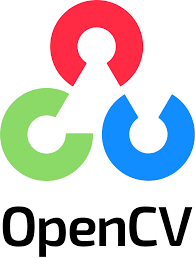

In [ ]:
import cv2
import os
from tqdm import tqdm # a random progress bar library, makes some things prettier

# Update paths to be within Google Drive
png_directory = '/content/drive/My Drive/Desmos Renderer/1. PNG Frames of the mp4'

# Ensure the PNG output directory exists
os.makedirs(png_directory, exist_ok=True)

def extract_frames_to_png(video_path, output_dir):
    # Open the video file
    video = cv2.VideoCapture(video_path)
    if not video.isOpened():
        raise Exception(f"Error opening video file: {video_path}")

    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"Total frames in video: {total_frames}")

    with tqdm(total=total_frames, desc="Extracting frames") as pbar: # Progress bar stuff
        frame_id = 0
        while True:
            success, frame = video.read()
            if not success:
                break

            # Construct the output filename
            frame_filename = os.path.join(output_dir, f"frame_{frame_id:04d}.png")

            # Save the frame as a PNG file
            cv2.imwrite(frame_filename, frame)

            frame_id += 1
            pbar.update(1)

    video.release()
    print(f"Extraction complete. {frame_id} frames saved to {output_dir}")

# Find the first MP4 file
video_files = [f for f in os.listdir(input_dir) if f.endswith('.mp4')]
if not video_files:
    raise Exception("No MP4 files found in the input directory")

video_path = os.path.join(input_dir, video_files[0])

# Extract frames and save as PNGs
extract_frames_to_png(video_path, png_directory)

## Part 2: converting the png to display on desmos

Desmos doesn't take pngs, however, we can use potrace to "trace" over the png and get a .svg file, which are vector graphics made from bezier curves. If we can read the bezier curves from the .svg files, then we can put them on desmos and get our image.

However, the images look better if we run them through Canny edge detection first. Also, potrace only takes .pnm files, so we need to convert to that.

So this is our procedure in this part:
- use Canny edge detection on each frame
- use ImageMagick to convert these frames into .pnm files
- use Potrace on the .pnm files to get the .svg files we need

---



Junferno's video explains why he chose to go through this process really well. again, go watch his video. <3

### Part 2a: Canny Edge Detector

Tracing through the .png frames once with Canny edge detector will make the frames prettier.

It uggghhh, sort of turns the image black and white and outlines the image nicely (i still dont fully know the details):

[Read the wikipedia page](https://en.wikipedia.org/wiki/Canny_edge_detector)
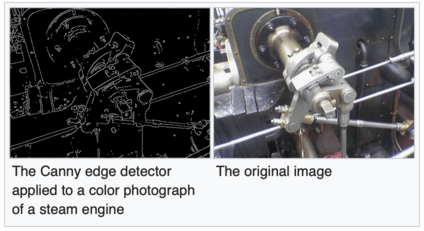

oh wow OpenCV has a built-in [Canny edge detector](https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html) function, we will be using that.

In [ ]:
# Ensure the Edge Frames directory exists
edge_directory = '/content/drive/My Drive/Desmos Renderer/2. Frames that has been Canny edge detected'
os.makedirs(edge_directory, exist_ok=True)

def apply_canny_to_frames(input_dir, output_dir):
    # List all PNG files in the input directory
    frame_files = sorted([f for f in os.listdir(input_dir) if f.endswith('.png')])

    if not frame_files:
        raise Exception(f"No PNG frames found in the directory: {input_dir}")

    print(f"Total frames to process: {len(frame_files)}")

    with tqdm(total=len(frame_files), desc="Applying Canny edge detection") as pbar:
        for frame_file in frame_files:
            # Read the frame
            frame_path = os.path.join(input_dir, frame_file)
            frame = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale for Canny

            # Apply Canny edge detection
            edges = cv2.Canny(frame, 50, 150)

            # Construct the output filename
            edge_filename = os.path.join(output_dir, frame_file)

            # Save the edge-detected frame
            cv2.imwrite(edge_filename, edges)

            pbar.update(1)

    print(f"Canny edge detection complete. Edge frames saved to {output_dir}")

# Apply Canny edge detector to all PNG frames
apply_canny_to_frames(png_directory, edge_directory)



In [ ]:
# Get PNG files of the edge-detected frames
import glob

def get_png_files(folder_path):

    # Ensure the folder exists
    if not os.path.exists(folder_path):
        raise Exception(f"Folder not found: {folder_path}")

    # Get all PNG files
    png_files = glob.glob(os.path.join(folder_path, "*.png"))
    print(f"Found {len(png_files)} PNG files")
    return png_files

png_files = get_png_files(edge_directory)


### Part 2b: PNG to PNM

Now that we have the Canny edge frames, we can (try to) shove the frames into potrace now.

However, potrace only accepts .pnm files (i have never heard of this before this project), so we need to convert the frames to that first.

Check out this q&a: https://potrace.sourceforge.net/faq.html

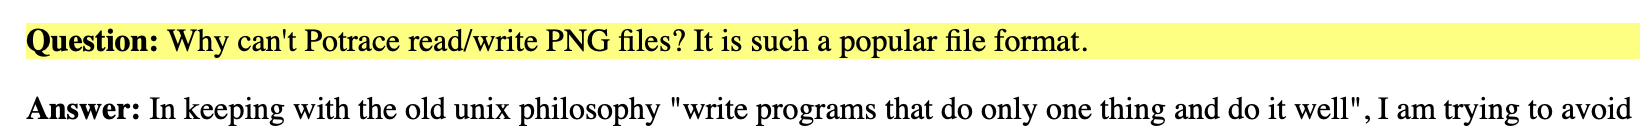

In [ ]:
# Convert PNG to PNM using ImageMagick
# I used this guys tutorial: https://www.youtube.com/watch?v=NUug23druVg

# UPDATE: THIS THING SUCKS OMG IT'S SO SLOW
# I COMMENTED OUT THIS BLOCK, USE THE CV2 METHOD IN THE NEXT BLOCK


# import subprocess
# from pathlib import Path
# from tqdm import tqdm

# def convert_to_pnm(png_files):
#     pnm_files = []
#     temp_dir = "/content/temp_pnm"  # Temporary directory for PNM files

#     # Create temporary directory if it doesn't exist
#     os.makedirs(temp_dir, exist_ok=True)

#     with tqdm(total=len(png_files), desc="Converting PNG to PNM") as pbar:
#         for png_file in png_files:
#             # Create output PNM filename
#             base_name = Path(png_file).stem
#             pnm_file = os.path.join(temp_dir, f"{base_name}.pnm")

#             # Convert PNG to PNM using ImageMagick
#             command = f"convert '{png_file}' '{pnm_file}'"
#             subprocess.run(command, shell=True, check=True)

#             pnm_files.append(pnm_file)
#             # print(f"Converted {base_name}.png to PNM")
#             pbar.update(1)

#     return pnm_files

# # Call the function to convert PNG files to PNM
# pnm_files = convert_to_pnm(png_files)


In [ ]:
import subprocess
from pathlib import Path
from tqdm import tqdm

def convert_to_pnm(png_files):
    pnm_files = []
    temp_dir = "/content/temp_pnm"  # Temporary directory for PNM files

    # Create temporary directory if it doesn't exist
    os.makedirs(temp_dir, exist_ok=True)

    with tqdm(total=len(png_files), desc="Converting PNG to PNM") as pbar:
        for png_file in png_files:
            # Create output PNM filename
            base_name = Path(png_file).stem
            pnm_file = os.path.join(temp_dir, f"{base_name}.pnm")

            # Read PNG image
            image = cv2.imread(png_file, cv2.IMREAD_UNCHANGED)  # Keep original channels

            if image is None:
                print(f"Error reading {png_file}")
                continue  # Skip if unable to read

            # Save as PNM
            cv2.imwrite(pnm_file, image)

            pnm_files.append(pnm_file)
            pbar.update(1)

    return pnm_files

# Call the function to convert PNG files to PNM
pnm_files = convert_to_pnm(png_files)

### Part 2c: Using Potrace to get the .SVG files

and finally we are potrace ready. Potrace and image magick don't run directly in python (I think this is the right way of describing them?), they are usually command line programs that run via commands in the terminal, so I did some googling (and chatgpting) and found that subprocess can handle this. This is so cool:



```
# Convert PNM to SVG using Potrace
command = f"potrace '{pnm_file}' -s -o '{svg_file}'"
subprocess.run(command, shell=True, check=True)
```
*this is the part that runs the potrace command*


In [ ]:
# Convert PNM to SVG using Potrace
import shutil

# Define the output directory for SVG files
svg_directory = '/content/drive/My Drive/Desmos Renderer/3. Frames Traced by Potrace'
os.makedirs(svg_directory, exist_ok=True)  # Create output directory if it doesn't exist

def convert_to_svg(pnm_files):

    with tqdm(total=len(pnm_files), desc="Converting PNM to SVG") as pbar:
        for pnm_file in pnm_files:
            # Create output SVG filename
            base_name = Path(pnm_file).stem
            svg_file = os.path.join(svg_directory, f"{base_name}.svg")

            # Convert PNM to SVG using Potrace
            command = f"potrace '{pnm_file}' -s -o '{svg_file}'"
            subprocess.run(command, shell=True, check=True)

            # print(f"Converted {base_name}.pnm to SVG")
            pbar.update(1)

    # Clean up temporary PNM files
    shutil.rmtree("/content/temp_pnm")
    print("\nConversion complete! SVG files saved to '3. Frames Traced by Potrace' folder")

# Call the function to convert PNM files to SVG
convert_to_svg(pnm_files)


In [ ]:
# This cell block was used to check the potrace frames
import os
svg_directory = '/content/drive/My Drive/Desmos Renderer/3. Frames Traced by Potrace'

# List all SVG files in the folder
svg_files = [os.path.join(svg_directory, f) for f in os.listdir(svg_directory) if f.endswith('.svg')]
svg_files.sort(key=lambda x: int(x.split('frame_')[1].split('.')[0]))
# Print the SVG files found
print("SVG files found:")
for file in svg_files:
    print(file)


## Part 3: Extracting the Bezier curve equations from the .SVG files

This part actually had an ounce of originality (makes me feel better about not copying junferno's entire video).

Chapter 6-9 in the big video covers what happened here. Basically, these .svg files are made of a bunch of "paths," I found a library called svgpathtools that has an svg2path function.

This allows us to parse the .svg files and output a list of bezier curves that makes up the file.

For more information on svg paths, go read this article: https://css-tricks.com/svg-path-syntax-illustrated-guide/


```
for frames in svg_files:

        paths, attributes = svg2paths(frames)
        create_html_template()

        # Iterate through paths and segments, storing them as strings
        for i, path in enumerate(paths):
            for segment in path:
                segment_str = f"{type(segment).__name__} - {segment}"
                add_expression_to_html(parse_input(segment_str))

```

This is basically what the code in the following blocks do:

- Loop through each frame
- Run the svg2path function to get all the paths and their attributes
- Create an HTML file for each frame
- Loops through each path tag (which may contain multiple beziers/lines)
- Loop through each bezier/line
- And turn them into nicely formatted strings like this (parse_input):

```
"CubicBezier - CubicBezier(start=(683+150j), control1=(683+180j), control2=(684+185j), end=(687+164j))"
"Line - Line(start=(687+164j), end=(691+133j))"
```

Then I did some string comprehension to extract the points for the CubicBeziers and Lines, and put them into their respective equations.

After this, it's a matter of loading these equations into Desmos.

(I dont think i explained this part too well, read through the code though the svg2path function isnt even ran until part 5)


In [ ]:
def parse_input(input_string):
    # Check the first word to determine the type of input
    if input_string.startswith("CubicBezier"):
        # Extract parts for CubicBezier
        parts = input_string.split(', ')
        start = complex(parts[0].split('=')[1].strip('CubicBezier(start=()'))
        control1 = complex(parts[1].split('=')[1].strip('()'))
        control2 = complex(parts[2].split('=')[1].strip('()'))
        end = complex(parts[3].split('=')[1].strip('()'))

        # Construct and return the equation
        equation = (
            f"((1-t)^3 * {start.real} + 3(1-t)^2t * {control1.real} + 3(1-t)t^2 * {control2.real} + t^3 * {end.real}, "
            f"(1-t)^3 * {start.imag} + 3(1-t)^2t * {control1.imag} + 3(1-t)t^2 * {control2.imag} + t^3 * {end.imag})"
        )
        return equation

    elif input_string.startswith("Line"):
        # Extract parts for Line
        parts = input_string.split(', ')
        start = complex(parts[0].split('=')[1].strip('Line(start=()'))
        end = complex(parts[1].split('=')[1].strip('()'))

        # Construct and return the equation
        equation = (
            f"((1-t) * {start.real} + t * {end.real}, (1-t) * {start.imag} + t * {end.imag})"
        )
        return equation

    else:
        return "Input string does not match expected patterns."

# Example usage
input1 = "CubicBezier - CubicBezier(start=(683+150j), control1=(683+180j), control2=(684+185j), end=(687+164j))"
input2 = "Line - Line(start=(687+164j), end=(691+133j))"

print(parse_input(input1))
print(parse_input(input2))

## Part 4: Loading the equations onto Desmos via Desmos API and an HTML file

I followed the instructions and set up a desmos instance in HTML using their documentation: https://www.desmos.com/api/v1.10/docs/index.html.

This part is pretty bizzare (to me): I stored the html code in a string in python, then made a new html file and shoved the code inside.

For every new equation (that we got earlier from svg2paths), I added it as a latex equation under the script tag.

(ps i hard coded the boundaries in setMathBounds, if the animation is too small/large try messing with these)

In [ ]:
# HTML functions to create an HTML file and add frames
import os

# Function to create the initial HTML template
def create_html_template(filename="index.html"):
    template = '''<!DOCTYPE html>
<html>
<head>
<script src="https://www.desmos.com/api/v1.10/calculator.js?apiKey=dcb31709b452b1cf9dc26972add0fda6"></script>
</head>
<body>
<div id="calculator" style="width: 100%; height: 100vh;"></div>
<div id="displayArea" class="display-area">
        Initial content
    </div>
<script>
    var elt = document.getElementById("calculator");
    var calculator = Desmos.GraphingCalculator(elt);

    calculator.setMathBounds({ // the windows size
      left: -10 * 500 + 4500,
      right: 10 * 500 + 4500 * 3,
      bottom: -7.60563 * 500 + 2500,
      top: 7.60563 * 500 + 2500 * 3
    });

    // Append new expressions here

    // Callback function
    function finishedLoading() {
      document.getElementById('displayArea').textContent = 'Content done loading!';
      console.log('Content done loading');
    }

    // Generate an async screenshot as an example of interaction
    calculator.asyncScreenshot(
      {
        mode: 'contain',
      },
      finishedLoading
    );
</script>
</body>
</html>
'''

    # Save the HTML template to the specified file
    with open(filename, "w") as file:
        file.write(template)
    # print(f"HTML template created: {os.path.abspath(filename)}")

# Function to add expressions to the HTML file
def add_expression_to_html(expression, filename="index.html"):
    if not os.path.exists(filename):
        raise FileNotFoundError(f"The file '{filename}' does not exist.")

    # Read the current contents of the file
    with open(filename, "r") as file:
        lines = file.readlines()

    # Find the line containing the comment where new expressions are appended
    for i, line in enumerate(lines):
        if "// Append new expressions here" in line:
            # Create the new expression code
            new_line = f"""\t\tcalculator.setExpression({{ latex: '{expression}' }});\n"""
            lines.insert(i + 1, new_line)  # Add the new expression after the comment
            break

    # Write the updated content back to the file
    with open(filename, "w") as file:
        file.writelines(lines)
    # print(f"Added expression: {expression} to {os.path.abspath(filename)}")

# Example usage:
create_html_template("index.html")  # Create the template HTML file
add_expression_to_html("y=x^2", "index.html")  # Add an example expression

## Part 5: Displaying the HTML via Selenium and taking a screenshot

If you scroll down all the way to the bottom of the colab notebook and run that html code block, you'll find that we can already display the desmos webpage, pretty nice.

I wanted to take a screenshot of the entire browser though, so I opted to use Selenium.

In [ ]:
# Import necessary libraries (i prob repeated a few imports oh well shouldnt matter too much)
from IPython.display import clear_output, Image, display
from svgpathtools import svg2paths
import time
import os
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# Create output directories in Google Drive
output_dir = '/content/drive/My Drive/Desmos Renderer/4. Rendered Desmos Screenshots'
failed_dir = '/content/drive/My Drive/Desmos Renderer/Failed Desmos Screenshots'
os.makedirs(output_dir, exist_ok=True)
os.makedirs(failed_dir, exist_ok=True)

# Set up Selenium and Chrome options
chrome_options = Options()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")
# Performance optimizations (do these even do anything)
chrome_options.add_argument("--disable-gpu")
chrome_options.add_argument("--disable-software-rasterizer")
chrome_options.add_argument("--disable-extensions")
chrome_options.add_argument("--disable-infobars")
chrome_options.add_argument("--disable-notifications")
chrome_options.add_argument("--disable-popup-blocking")

# Start Chrome WebDriver
driver = webdriver.Chrome(options=chrome_options)
# Set the browser window size to 1080p
driver.set_window_size(1920, 1080)

# massive_html_list = []

# This allows you to skip frames you already rendered
# (sometimes colab disconnects you, so I used this to continue my renders)
already_rendered = 597 # @param

try:
    for frames in svg_files:
        frame_number = int(frames.split('frame_')[1].split('.')[0])

        if frame_number <= already_rendered:
            print(f"Skipping frame {frame_number} (already rendered)")
            continue

        print(f"Processing SVG file: {frames}")

        paths, attributes = svg2paths(frames)

        create_html_template()

        # Iterate through paths and segments, storing them as strings
        for i, path in enumerate(paths):
            for segment in path:
                segment_str = f"{type(segment).__name__} - {segment}"
                add_expression_to_html(parse_input(segment_str))

        try:
            # Load the file in the browser
            driver.get("file://" + "/content/index.html")

            # Wait for the display area content to change
            print("Waiting for display area content to change...")
            WebDriverWait(driver, 120).until(
                EC.text_to_be_present_in_element((By.ID, 'displayArea'), 'Content done loading!')
            )
            print("Content changed, proceeding...")
            time.sleep(0.1)

            # Generate output filename
            svg_filename = os.path.basename(frames)
            screenshot_path = os.path.join(output_dir, f"output_{svg_filename.replace('.svg', '.png')}")

            # Save screenshot to Google Drive
            driver.save_screenshot(screenshot_path)
            print(f"Saved: {screenshot_path}")

        except Exception as e:
            print(f"Failed to process frame {frame_number}: {str(e)}")

            # Move failed frame to failed directory
            failed_frame_path = os.path.join(failed_dir, os.path.basename(frames))
            os.rename(frames, failed_frame_path)
            print(f"Moved failed frame to: {failed_frame_path}")

        # Clear output to prevent notebook from getting too long
        clear_output(wait=True)

except Exception as e:
    print(f"An error occurred: {str(e)}")
finally:
    # Always close the browser
    driver.quit()

print("Processing complete! Check the corresponding folders in your Google Drive.")


## Part 6: Stitching the PNG frames together into an MP4 file

Finally, we'll compile all the PNG frames together and stitch them into one mp4 file. I found that cv2 has a function for this too, really powerful stuff.

Remember to set the correct framerate though, I set it to 30 because that was what the videos I used were.

In [ ]:
from google.colab import drive
import cv2
import os
from natsort import natsorted

# Input and output directories
input_dir = '/content/drive/My Drive/Desmos Renderer/4. Rendered Desmos Screenshots'
output_dir = '/content/drive/My Drive/Desmos Renderer/'  # Output folder for the MP4 file
output_filename = 'output_video.mp4'  # Name of the output video file

# Frame rate
frame_rate = 30  # @param

# Get list of all PNG files in the directory
image_files = [f for f in os.listdir(input_dir) if f.endswith('.png')]
image_files = natsorted(image_files)  # Sort files naturally

# Ensure there are images to process
if not image_files:
    print("No PNG files found in the directory.")
else:
    # Read the first image to get frame dimensions
    first_image_path = os.path.join(input_dir, image_files[0])
    frame = cv2.imread(first_image_path)
    height, width, layers = frame.shape

    # Define the codec and create VideoWriter object
    video_path = os.path.join(output_dir, output_filename)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for MP4
    video = cv2.VideoWriter(video_path, fourcc, frame_rate, (width, height))

    # Add images to video
    for img_file in image_files:
        img_path = os.path.join(input_dir, img_file)
        print(f"Adding image: {img_path}")
        frame = cv2.imread(img_path)
        video.write(frame)

    # Release the video writer
    video.release()
    print(f"Video saved to {video_path}")


And that's the entire program, thanks for looking through this.

Here's the accompanying video again: https://youtu.be/4dx3xqoDRgQ

Go subscribe to Junferno as well: https://www.youtube.com/@Junferno

In [ ]:
# This cell is left over from earlier testings, it displays the html file that goes to desmos

%%html
<!DOCTYPE html>
<html>
<head>
<script src="https://www.desmos.com/api/v1.10/calculator.js?apiKey=dcb31709b452b1cf9dc26972add0fda6"></script>
</head>
<body>
<div id="calculator" style="width: 100%; height: 100vh;"></div>
<div id="displayArea" class="display-area">
        Initial content
    </div>
<script>
    var elt = document.getElementById("calculator");
    var calculator = Desmos.GraphingCalculator(elt);

    calculator.setMathBounds({ // the windows size
      left: -10 * 500 + 4500,
      right: 10 * 500 + 4500,
      bottom: -7.60563 * 500 + 2500,
      top: 7.60563 * 500 + 2500
    });

    // Append new expressions here
		calculator.setExpression({ latex: 'y=x^2' });

    // Callback function
    function finishedLoading() {
      document.getElementById('displayArea').textContent = 'Content done loading!';
      console.log('Content done loading');
    }

    // Generate an async screenshot as an example of interaction
    calculator.asyncScreenshot(
      {
        mode: 'contain',
      },
      finishedLoading
    );
</script>
</body>
</html>
